In [26]:
!pip install pmdarima
!pip install optuna
!pip install pandas-ta
!pip install catbost
!pip install prophet
!pip install finance-datareader
!pip install neuralprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=107c8598262558160410b7215a22e4aac21572563a69e5a6751b68af38aabc5b
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta
ERROR: Could not find a version that satisfies the requirement catbost (from versions: none)
ERROR: No matching distribution found for catbost
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [54]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.auto import tqdm
from xgboost import XGBRegressor
import optuna
import pandas_ta as ta
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import auto_arima
import FinanceDataReader as fdr
from neuralprophet import NeuralProphet
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import random
import itertools
import warnings
warnings.filterwarnings("ignore")

In [29]:
def seed_everything(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)

seed_everything(6789)

In [30]:
train = pd.read_csv("/content/drive/MyDrive/dacon_trading_bot/train.csv")

In [73]:
results_df = pd.DataFrame(columns=["종목코드", "final_return"])
unique_codes = train["종목코드"].unique()
for idx, code in tqdm(enumerate(unique_codes), total=len(unique_codes)):
  train_close = train[train["종목코드"]==code][["일자", "종가"]]
  train_close["일자"] = pd.to_datetime(train_close["일자"], format="%Y%m%d")
  train_close.rename(columns={"일자":"ds", "종가":"y"}, inplace=True)

  # facebook prophet
  prophet_model = Prophet()
  prophet_model.fit(train_close)
  future = prophet_model.make_future_dataframe(periods=15, freq="d")
  forecast = prophet_model.predict(future)
  prophet_final_return = (forecast["yhat"].iloc[-1] - forecast["yhat"].iloc[0]) / forecast["yhat"].iloc[0]

  # MLP Regressor
  scaler = StandardScaler()
  train_scaled = scaler.fit_transform(train_close[["y"]])
  mlp = MLPRegressor(hidden_layer_sizes=(50, ), max_iter=1000)
  mlp.fit(train_scaled[:-1], train_scaled[1:])
  mlp_forecast_scaled = np.zeros(15)
  last_value = train_scaled[-1]
  for i in range(15):
    last_value = mlp.predict(last_value.reshape(-1, 1))
    mlp_forecast_scaled[i] = last_value
  mlp_forecast = mlp_forecast_scaled * scaler.scale_[0] + scaler.mean_[0]
  mlp_final_return = (mlp_forecast[-1] - mlp_forecast[0]) / mlp_forecast[0]

  # ARIMA
  p = d = q = range(0, 3)
  pdq = list(itertools.product(p, d, q))
  best_aic = np.inf
  best_pdq = None
  for param in tqdm(pdq, desc="tuning ARIMA"):
    try:
      arima_model = ARIMA(train_close["y"], order=param)
      arima_model_fit = arima_model.fit()
      if arima_model_fit.aic < best_aic:
        best_aic = arima_model_fit.aic
        best_pdq = param
    except:
      continue
  arima_model = ARIMA(train_close["y"], order=best_pdq)
  arima_model_ift = arima_model.fit()
  arima_forecast = arima_model_fit.predict(start=len(train_close), end=len(train_close)+15)
  arima_final_return = (arima_forecast.iloc[-1] - arima_forecast.iloc[0]) / arima_forecast.iloc[0]
  ensemble_forecast = (arima_final_return + mlp_final_return + prophet_final_return)/3

  results_df = results_df.append({"종목코드":code, "final_return":ensemble_forecast}, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/xdzf__to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/grz0rxvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21449', 'data', 'file=/tmp/tmpphrthmyx/xdzf__to.json', 'init=/tmp/tmpphrthmyx/grz0rxvt.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelvhfqdgn7/prophet_model-20230706035443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/3vorra6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/4c94hdx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77884', 'data', 'file=/tmp/tmpphrthmyx/3vorra6l.json', 'init=/tmp/tmpphrthmyx/4c94hdx8.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelkrqllq12/prophet_model-20230706035447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/6yw8wdex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/urmtmux4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46316', 'data', 'file=/tmp/tmpphrthmyx/6yw8wdex.json', 'init=/tmp/tmpphrthmyx/urmtmux4.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelqc3fszz9/prophet_model-20230706035450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/bs38_qj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/p077frc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2464', 'data', 'file=/tmp/tmpphrthmyx/bs38_qj2.json', 'init=/tmp/tmpphrthmyx/p077frc1.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelqc7yjx4a/prophet_model-20230706035455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/5eemjmxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/7y_omkkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28681', 'data', 'file=/tmp/tmpphrthmyx/5eemjmxd.json', 'init=/tmp/tmpphrthmyx/7y_omkkz.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelywof2jd8/prophet_model-20230706035458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/0ccey2eb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/v1ghk5b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17125', 'data', 'file=/tmp/tmpphrthmyx/0ccey2eb.json', 'init=/tmp/tmpphrthmyx/v1ghk5b8.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelbgia3inr/prophet_model-20230706035502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/hsf3fcpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/1u2ja1s9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15895', 'data', 'file=/tmp/tmpphrthmyx/hsf3fcpo.json', 'init=/tmp/tmpphrthmyx/1u2ja1s9.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelgn8zo79r/prophet_model-20230706035505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/vm8bucib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/ch3x5nws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1676', 'data', 'file=/tmp/tmpphrthmyx/vm8bucib.json', 'init=/tmp/tmpphrthmyx/ch3x5nws.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_model8bpwnige/prophet_model-20230706035509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/yeru1qr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/v9vxw18_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74629', 'data', 'file=/tmp/tmpphrthmyx/yeru1qr8.json', 'init=/tmp/tmpphrthmyx/v9vxw18_.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_model5cwrp32_/prophet_model-20230706035513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/g6q9ogr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/_qiyfcxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21676', 'data', 'file=/tmp/tmpphrthmyx/g6q9ogr3.json', 'init=/tmp/tmpphrthmyx/_qiyfcxb.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_model7749jajj/prophet_model-20230706035516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/qqtwk3sa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpphrthmyx/llmnxizr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84566', 'data', 'file=/tmp/tmpphrthmyx/qqtwk3sa.json', 'init=/tmp/tmpphrthmyx/llmnxizr.json', 'output', 'file=/tmp/tmpphrthmyx/prophet_modelhz1z3hxj/prophet_model-20230706035520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


tuning ARIMA:   0%|          | 0/27 [00:00<?, ?it/s]

In [74]:
results_df["순위"] = results_df["final_return"].rank(ascending=False).astype("int")
results_df

,종목코드,final_return,순위
0,A060310,-0.149721,10
1,A095570,-0.061202,6
2,A006840,-0.184520,11
3,A054620,-0.071305,7
4,A265520,-0.125775,8
5,A211270,0.092058,2
6,A027410,-0.134930,9
7,A282330,0.018156,4
8,A126600,0.214141,1
9,A138930,-0.058432,5


In [75]:
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon_trading_bot/sample_submission.csv")
baseline_ensemble_submission = sample_submission[["종목코드"]].merge(results_df[["종목코드", "순위"]], on="종목코드", how="left")
baseline_ensemble_submission.to_csv("/content/drive/MyDrive/dacon_trading_bot/baseline_ensemble_submission.csv", index=False)

In [105]:
'''

results_df = pd.DataFrame(columns=["종목코드", "final_return"])

unique_codes = train["종목코드"].unique()

for idx, code in tqdm(enumerate(unique_codes), total=len(unique_codes), desc="processing each ticker"):
  start_date = "20000101"
  end_date = "20230530"
  stock = fdr.DataReader(code[1:], start=start_date, end=end_date)
  stock = stock.iloc[:, :-1]
  stock.rename(columns={"Open": "시가", "High":"고가", "Low": "저가", "Close": "종가", "Volume": "거래량"}, inplace=True)
  stock["일자"] = pd.to_datetime(stock.index, format="%Y%m%d")
  stock = stock[["일자", "종가"]]
  stock.rename(columns={"일자":"ds", "종가":"y"}, inplace=True)
  fb_prophet = Prophet()
  fb_prophet.fit(stock)
  future = fb_prophet.make_future_dataframe(periods=15, freq="d")
  forecast = fb_prophet.predict(future)
  final_return = (forecast["yhat"].iloc[-1] - forecast["yhat"].iloc[0]) / forecast["yhat"].iloc[0]
  results_df = results_df.append({"종목코드":code, "final_return": final_return}, ignore_index=True)

'''


processing each ticker:   0%|          | 0/2000 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_k7wu4h/4w4l0i9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_k7wu4h/zvr1tewr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90168', 'data', 'file=/tmp/tmpj_k7wu4h/4w4l0i9h.json', 'init=/tmp/tmpj_k7wu4h/zvr1tewr.json', 'output', 'file=/tmp/tmpj_k7wu4h/prophet_model45hjqnqy/prophet_model-20230705090155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:01:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:01:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_

KeyboardInterrupt: ignored

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_Trader(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM_Trader, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.output_dim = output_dim
    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
    self.fc = nn.Linear(self.hidden_dim, self.output_dim)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out)
    return out

In [95]:
unique_codes = train["종목코드"].unique()

results_df = pd.DataFrame(columns=["종목코드", "final_return"])

for idx, code in tqdm(enumerate(unique_codes[7:]), total=len(unique_codes)):
  print(f"===== processing data {idx+1}/2000 ======")
  start_date = "20000101"
  end_date = "20230530"
  stock = fdr.DataReader(code[1:], start=start_date, end=end_date)
  stock = stock.iloc[:, :-1]
  stock.rename(columns={"Open": "시가", "High":"고가", "Low": "저가", "Close": "종가", "Volume": "거래량"}, inplace=True)
  stock["일자"] = pd.to_datetime(stock.index, format="%Y%m%d")
  stock.drop(columns={"일자"}, inplace=True)
  close = stock["종가"].values
  X, Y = [], []
  for i in range(15, stock.shape[0]-15):
    cur_x = stock.iloc[i-15:i].values
    cur_y = (close[i+15] - close[i]) / close[i]
    X.append(cur_x)
    Y.append(cur_y)
  X = torch.tensor(np.array(X)).float()
  Y = torch.tensor(Y).float()
  X_test = stock.iloc[-15:].values
  X_test = torch.tensor(np.array(X_test)).float()
  X_test = torch.reshape(X_test, (-1, 15, 5))

  train_size = int(X.shape[0] * 0.9) # 9:1 split
  X_train = X[:train_size]
  Y_train = Y[:train_size]
  X_val = X[train_size:]
  Y_val = Y[train_size:]
  mu, std = torch.mean(X_train), torch.std(X_train)
  X_train = (X_train - mu) / std
  X_val = (X_val - mu) / std
  X_test = (X_test - mu) / std

  train_data = TensorDataset(X_train, Y_train)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

  val_data = TensorDataset(X_val, Y_val)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=128)

  model = LSTM_Trader(input_dim=5, hidden_dim=50, num_layers=2, output_dim=1).to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
  epochs = 40
  total_steps = len(train_dataloader) * epochs
  loss_func = nn.SmoothL1Loss()
  best_val_loss = 99999999999
  best_model = None
  model.zero_grad()

  val_losses = []
  for epoch in tqdm(range(epochs), total=epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_seqs, b_targets = batch
      outputs = model(b_seqs)
      loss = loss_func(outputs, b_targets)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      model.zero_grad()
    val_loss = 0
    model.eval()
    for step, batch in enumerate(val_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_seqs, b_targets = batch
      with torch.no_grad():
        outputs = model(b_seqs)
      loss = loss_func(outputs, b_targets)
      val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_model = model

  best_model.eval()
  with torch.no_grad():
    final_return = best_model(X_test.to(device)).detach().cpu().numpy()[0][0]
  results_df = results_df.append({"종목코드":code, "final_return":final_return}, ignore_index=True)
  if idx == 10:
    break

  0%|          | 0/2000 [00:00<?, ?it/s]

===== processing data 1/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 2/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 3/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 4/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 5/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 6/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 7/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 8/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 9/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 10/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 11/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

In [92]:
results_df["순위"] = results_df["final_return"].rank(method="first").astype("int")
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon_trading_bot/sample_submission.csv")
lstm_submission = sample_submission[["종목코드"]].merge(results_df[["종목코드", "순위"]], on="종목코드", how="left")
lstm_submission.to_csv("/content/drive/MyDrive/dacon_trading_bot/lstm_baseline.csv", index=False)

In [93]:
results_df

,종목코드,final_return,순위
0,A282330,[0.040183797],11
1,A126600,[-0.00013687462],1
2,A138930,[0.006523736],3
3,A001460,[0.010348321],6
4,A013720,[0.022268265],9
5,A001040,[0.012817081],7
6,A079160,[0.0024542846],2
7,A035760,[0.009267246],5
8,A311690,[0.034805063],10
9,A000120,[0.008775599],4


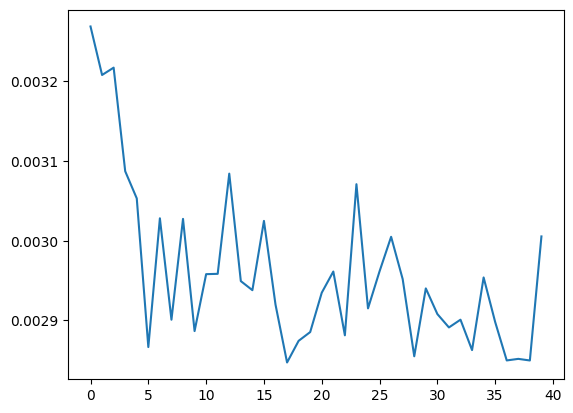

In [96]:
plt.plot(val_losses)

In [87]:
results_df

,종목코드,final_return,순위
0,A282330,[0.013759688],10
1,A126600,[-0.000577122],2
2,A138930,[-0.0035121394],1
3,A001460,[0.008928761],7
4,A013720,[0.018268337],11
5,A001040,[0.0076376647],5
6,A079160,[0.005124956],4
7,A035760,[0.008601759],6
8,A311690,[0.0029703535],3
9,A000120,[0.011639856],8
